![Astrofisica Computacional](../../logo.png)

---
## Imagenes FITS y el  World Coordinate System (WCS)


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Resumen

En este cuaderno se visualizará un archivo FITS y se calibrrá la imágen utilizando el **W**orld **C**oordinate **S**ystem (WCS)

---

## 1. Imágenes FITS y el WCS

Se trabajará con un archivo de imagen fotometrica del remanente de supernova [Cassiopeia A](https://en.wikipedia.org/wiki/Cassiopeia_A), descargado del [Chandra X-ray observatory](http://chandra.harvard.edu/).

### 1.1 Lectura del Archivo


In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


hdulist = fits.open('data/casa_0.5-1.5keV.fits.gz')
hdulist.info()

Filename: data/casa_0.5-1.5keV.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (1024, 1024)   float32   


El archivo solamente contiene un `PrimaryHDU` con dimensiones `(1024, 1024)` de numeros del tipo `float32`. Para acceder a la información hacemos

In [2]:
image_hdu = hdulist['PRIMARY'] 

#or

image_hdu = hdulist[0] 

y mediante el atributo  `.data` accedemos a la información,

In [3]:
image_hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis Length                                    
NAXIS2  =                 1024 / Axis Length                                    
OBJECT  = 'Cassiopeia A'                                                        
DATE-OBS= '2007-12-05T22:01:59'                                                 
DATE-END= '2007-12-08T20:07:24'                                                 
LTM1_1  =                    1                                                  
LTM1_2  =                    0                                                  
LTM2_1  =                    0                                                  
LTM2_2  =                    1                                                  
LTV1    =                -36

In [4]:
image_hdu.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Se nota que se obtuvo un arreglo 2D que puede visualizarse:

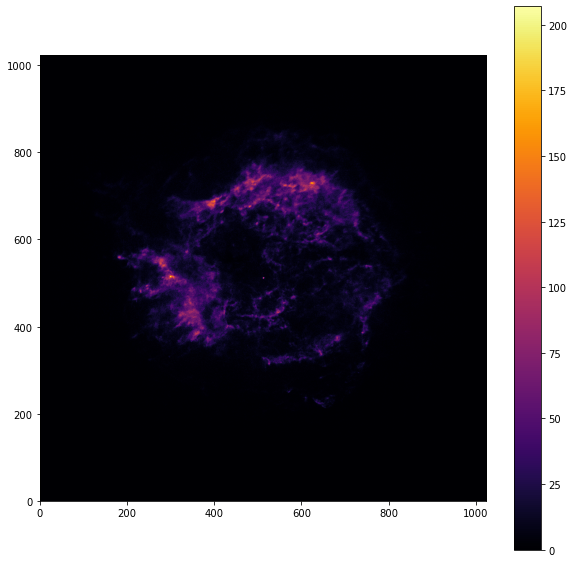

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image_hdu.data, origin='lower', cmap='inferno')
plt.colorbar();

La meta-información adicional esta en el header del primario,

In [6]:
image_hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis Length                                    
NAXIS2  =                 1024 / Axis Length                                    
OBJECT  = 'Cassiopeia A'                                                        
DATE-OBS= '2007-12-05T22:01:59'                                                 
DATE-END= '2007-12-08T20:07:24'                                                 
LTM1_1  =                    1                                                  
LTM1_2  =                    0                                                  
LTM2_1  =                    0                                                  
LTM2_2  =                    1                                                  
LTV1    =                -36

### 1.2 World Coordinate System (WCS)

Dentro del standard de FITS se utiliza el sistema de coordenadas mundial o World Coordinate System (WCS) como un mecanismo para asociar los valores físicos del archivo con posiciones reales. De esta forma, es posible convertir las coordenadas de los pixels en una imagen con coordenadas celestes como ascención recta (RA) y declinación (dec). 

La información contenida en el header permite crear la transformación de coordenadas de pixel a coordenadas celestes mediante [astropy.wcs.WCS](http://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS):

In [7]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

wcs = WCS(image_hdu.header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 350.8841248  58.78133011  
CRPIX : 445.5  289.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001366666693  0.0001366666693  
NAXIS : 1024  1024


Utilizando los métodos [SkyCoord.to_pixel()](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.to_pixel) y [SkyCood.from_pixel()](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.from_pixel), es posible convertir cada posición de la imagen a las correspondientes coordenadas en el cielo. Por ejemplo, el pixel ubicado en [0,0] tendrá coordenadas

In [8]:
SkyCoord.from_pixel(0, 0, wcs)

<SkyCoord (ICRS): (ra, dec) in deg
    (351.00119731, 58.74184873)>

Las coordenadas del remanente de supernova se pueden obtenr accediendo a los datos online mediante el nombre del objeto

In [9]:
position_casa = SkyCoord.from_name('Cas A')
position_casa

<SkyCoord (ICRS): (ra, dec) in deg
    (350.85, 58.815)>

También es posible registrar las coordenadas del objeto en forma manual (Nótese que se utiliza el sistema [ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame))

In [10]:
position_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')
position_casa

<SkyCoord (ICRS): (ra, dec) in deg
    (350.86641667, 58.81177778)>

Al comparar estos resultado con el obtenido para el pixel (0,0) se puede observar que no coinciden exactamente. Esto quiere decir que las coordenadas del objeto corresponden a otro pixel en la imagen. Para saber cual es realizamos:

In [11]:
#position_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')

# or

position_casa = SkyCoord.from_name('Cas A')

position_casa.to_pixel(wcs)

(array(573.79215824), array(534.89801134))

## 2. Visualización de imágenes en el cielo

Astropy provee de un modulo de ayuda [astropy.visualization.wcsaxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/) paa simplificar la inclusión de las coordenadas celestes den el gráfico de Matplotlib.

Para utilizarlo, solo es ncecesario pasar  el argumento `projection=wcs` a la función `plt.subplot()`:

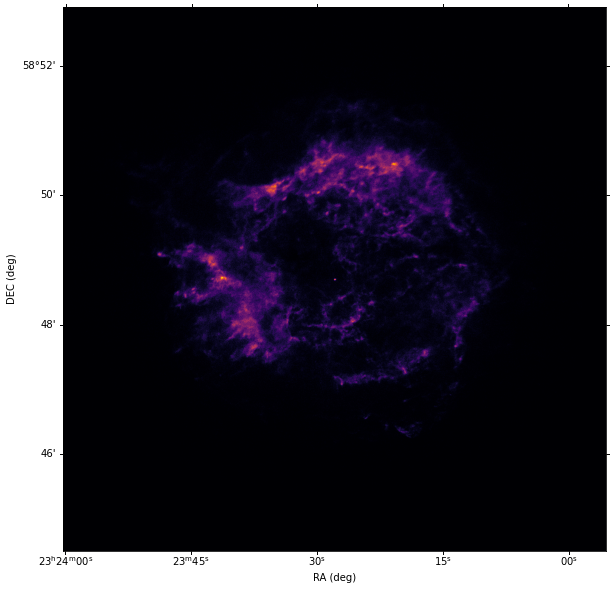

In [12]:
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(image_hdu.data, cmap='inferno', origin='lower')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

Al agregar una malla de coordenadas, `ax.grid()`, se tiene

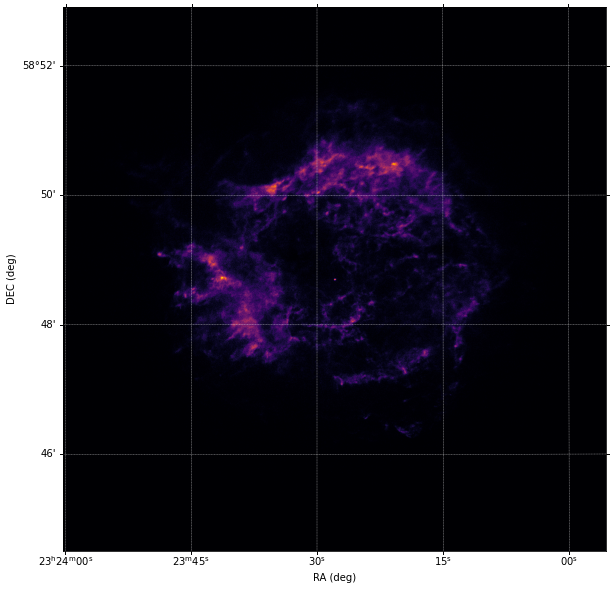

In [13]:
ax.grid(linewidth=0.3, linestyle='dashed', color='white')
ax.figure

Ahora, con una cruz blanca se señalará la posición de `'Cas A'`:

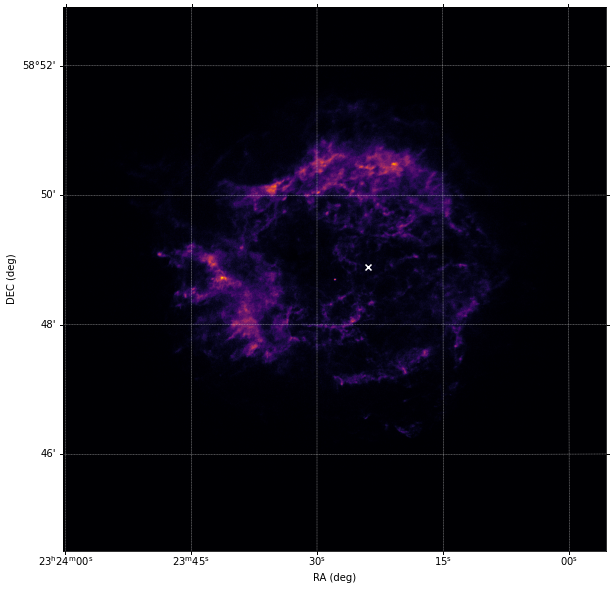

In [14]:
ra = position_casa.icrs.ra.deg
dec = position_casa.icrs.dec.deg
ax.scatter(ra, dec, transform=ax.get_transform('icrs'), color='white', marker='x')
ax.figure

También es posible agregar formas geométricas para ilustrar regiones de interes,

In [ ]:
from matplotlib.patches import Circle
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u

In [ ]:
# transform to pixel coordinates
xy = ax.wcs.world_to_pixel(position_casa)
pixel_size = proj_plane_pixel_scales(wcs)[0] * u.deg
radius = 2.3 * u.arcmin / pixel_size

In [ ]:
circle = Circle(
    xy=xy,
    radius=radius.to_value(""),
    edgecolor="w",
    facecolor="None"
)
ax.add_patch(circle)
ax.figure

Para información completa sobre formas mas complejas y el manejo de regiones en los gráficos, puede revisar el paquete [regions](https://astropy-regions.readthedocs.io/en/stable/).